# Setup

In [1]:
include("../lna.jl")
using DifferentialEquations, StatsBase, Plots, Distributions, LaTeXStrings, DataFrames, CSV, ProgressBars


function reaction(n)
    "
    ρ_m$(n), 0 --> M$(n)
    δ_m$(n), M$(n) --> 0
    σ_b$(n), M$(n) + R --> MR$(n)
    δ_u$(n), MR$(n) --> M$(n) + R
    ρ_p$(n), MR$(n) --> M$(n) + P$(n) + R
    δ_mr$(n), MR$(n) --> 0
    δ_p$(n), P$(n) --> 0
    "
end

function endstring(n)
    cumulative_string = "end ρ_r δ_r "
    for i in 1:n
        cumulative_string = string(cumulative_string, "ρ_m$(i) δ_m$(i) σ_b$(i) δ_u$(i) ρ_p$(i) δ_mr$(i) δ_p$(i) ")
    end
    cumulative_string
end

function generate_rn(n)
    rnstring = "rn = @reaction_network begin
        ρ_r, 0 --> R
        δ_r, R --> 0
    "
    for i in 1:n
        rnstring = string(rnstring, reaction(i))
    end
    rnstring = string(rnstring, endstring(n))
    rnexpression = Base.Meta.parse(rnstring)
    eval(rnexpression)
end

function generate_propensities(n)
    rand(Float64, (6*n+2))
end

function relative_error(true_val, approx_val)
    map(abs, 1 .- approx_val./true_val)
end

# Valid always
function FF_single_gene_ribosome(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5] - props[6] + props[7] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5]/props[6] + props[7]/ props[8] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_single_gene_ribosome_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_can_approx_sim(props, p, r)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7) * r
    return 1 + k3*k7/(k2*k6)
end

function FF_can(means, covs)
    covs[2,2]/means[2]
end

function FF_rib(means, covs)
    covs[3,3]/means[3]
end

function FF_rib_bound(means, covs)
    covs[3,3]/means[3]
end

function FF_rib_bound_int(means, covs)
    covs[4,4]/means[4]
end

function FF_wc(means, covs)
    covs[4,4]/means[4]
end

function rn_can_f()
    return @reaction_network begin
        k1, 0 --> m
        k2, m --> 0
        k3, m --> m + p
        k6, p --> 0
    end k1 k2 k3 k6
end

function rn_rib_f()
    return @reaction_network begin
        k1, 0 --> r
        k2, r --> 0
        k3, 0 --> m
        k4, m --> 0
        k5, m + r --> m + r + p
        k6, p --> 0
    end k1 k2 k3 k4 k5 k6
end

function rn_rib_bound_f()
    return @reaction_network begin
        k1, 0 --> r
        k2, r --> 0
        k3, 0 --> m
        k4, m --> 0
        k5, m + r --> m + r + p
        k6, p --> 0
        k7, r --> rb
        k8, rb --> r
        k9, rb --> 0
    end k1 k2 k3 k4 k5 k6 k7 k8 k9
end

function rn_rib_bound_int_f()
    return @reaction_network begin
        k1, 0 --> r
        k2, r --> 0
        k3, 0 --> m
        k4, m --> 0
        k5, m + r --> rs
        k6, rs --> m + r
        k7, rs --> m + r + p
        k8, p --> 0
        k9, rs --> 0 
        k10, r --> rb
        k11, rb --> r
        k12, rb --> 0
    end k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12
end

rn_rib_bound_int_f (generic function with 1 method)

# Verifying the LNA solution

In [22]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(ps, [1.5, .1, .2, .1, .5, .1, .1])
end

prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 5000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

protein_counts = map(x -> x[4], sol.u)

LoadError: InterruptException:

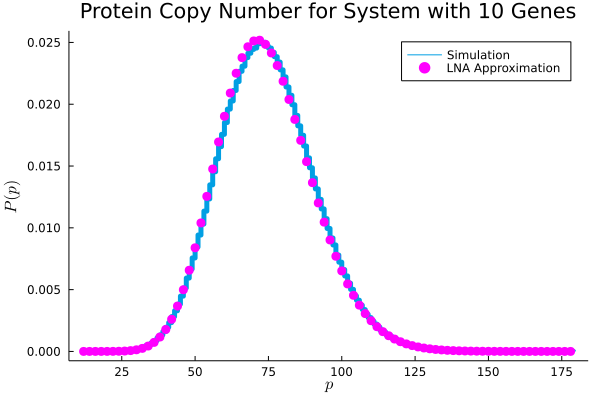

In [3]:
histogram(protein_counts, nbins=maximum(protein_counts), norm=true, label="Stochastic Simulation Algorithm")

prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

step=2
nb = NegativeBinomial(r,p)
xs = [minimum(protein_counts):step:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    title = "Protein Copy Number for System with $N Genes", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    markersize=5,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [4]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_genes.svg")

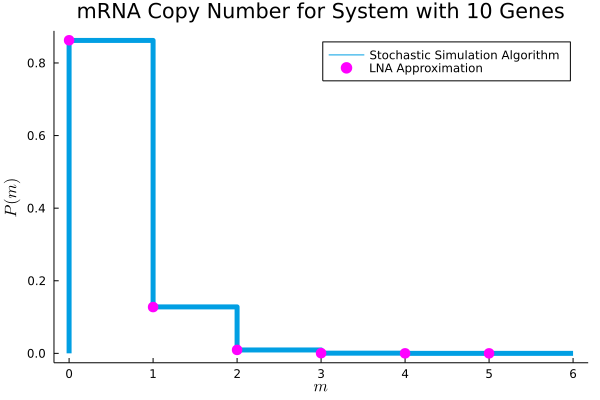

In [5]:
mrna_counts = map(x -> x[2], sol.u)
histogram(mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Stochastic Simulation Algorithm",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

m_mean = lnameans[2]
m_var = lnacovs[2,2]

p = m_mean/m_var
r = m_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)
scatter!(
    xs,
    ys,
    label="LNA Approximation", 
    title = "mRNA Copy Number for System with $(N) Genes",
    xlabel=L"m",
    ylabel=L"P(m)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [6]:
savefig("../../data/figures-for-paper/mrna_copy_number_$(N)_genes.svg")

## Matching models at the mean level.

In [63]:
N = 10
ps = [N*10*10*log(2)/1200., log(2)/1200.] # [ribosome production, ribosome degredation]
for j in 1:N
    ps = vcat(
        ps, 
        [
            rand(Normal(log(2)/210*5, 0.1*log(2)/210*5)), # mRNA creation
            rand(Normal(log(2)/210 + log(2)/1200, 0.1*log(2)/210 + log(2)/1200)), # mRNA degredation
            rand(Normal(.0001, 0.1*.0001)), # binding to polysome
            rand(Normal(0.0001, 0.00001)), # unbinding from polysome
            rand(Normal(0.1,0.01)), # translation,
            rand(Normal(log(2)/1200., 0.1*log(2)/1200.)), # monosome decay
            rand(Normal(log(2)/1200., 0.1*log(2)/1200)) # protein decay
        ]
    )
end

rn = generate_rn(10)

prob = LNAProblem(rn, zeros(Int, length(species(rn))), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

k3_values = ps[5+7:7:length(ps)]
k4_values = ps[6+7:7:length(ps)]
k5_values= ps[7+7:7:length(ps)]
k6 = ps[2]
m_values = lnameans[2+3:3:length(lnameans)]
sigma = sum((k3_values .- ((k4_values .+ k5_values) .* k3_values) ./ (k4_values .+ k5_values .+ k6)) .* m_values)

kb = 1
kmb = kb * sigma /(kb - sigma) 

2.084496781650035e-5

In [64]:
k3_values = ps[5:7:length(ps)]
k4_values = ps[6:7:length(ps)]
k5_values= ps[7:7:length(ps)]
k6 = ps[2]
m_values = lnameans[2:3:length(lnameans)]
sigma = sum((k3_values .- ((k4_values .+ k5_values) .* k3_values) ./ (k4_values .+ k5_values .+ k6)) .* m_values)

ps[1]/(ps[2] + sigma)

962.1124216170624

In [65]:
lnameans[4]

628.3700911447926

In [66]:
function ps_rib_bound_int_f(ps, lnameans)
    k3_values = ps[5+7:7:length(ps)]
    k4_values = ps[6+7:7:length(ps)]
    k5_values= ps[7+7:7:length(ps)]
    k6 = ps[2]
    m_values = lnameans[2+3:3:length(lnameans)]
    sigma = sum((k3_values .- ((k4_values .+ k5_values) .* k3_values) ./ (k4_values .+ k5_values .+ k6)) .* m_values)
    
    rib_binding = 0.001
    rib_unbinding = sigma / rib_binding - rib_binding + 1
    return [
        ps[1], # rib creation
        ps[2], # rib degredation
        ps[3], # mrna creation
        ps[4], # mrna degredation
        ps[5],# rib binding
        ps[6],# rib unbinding
        ps[7], # translation
        ps[2], # protein degredation = rib degredation
        ps[2], # monosome degredation
        rib_binding, # rib binding
        rib_unbinding, # rib unbinding
        ps[2], # bound ribosome degredation
    ]
end

ps_rib_bound_int_f (generic function with 1 method)

In [67]:
rn_bound_int = rn_rib_bound_int_f()

Model ##ReactionSystem#294 with 12 equations
States (5):
  r(t)
  m(t)
  rs(t)
  p(t)
  rb(t)
Parameters (12):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [71]:
prob = LNAProblem(rn_bound_int, zeros(Int, length(species(rn_bound_int))), ps_rib_bound_int_f(ps, lnameans))

sol = solve(prob)

lnameans_bound_int = mean(sol)
lnacovs_bound_int = StatsBase.cov(sol)

5×5 Matrix{Float64}:
 996.262        -0.327292     -0.276963      214.457     0.000543468
  -0.327292      3.87191      -0.00046173     56.7553   -0.000319225
  -0.276963     -0.00046173    3.31531        49.0569   -0.000271444
 214.457        56.7553       49.0569       9092.72      0.21002
   0.000543468  -0.000319225  -0.000271444     0.21002   0.975781

In [72]:
lnameans_bound_int

u: 5-element Vector{Float64}:
 995.7075955023874
   3.871212770018893
   3.3166244347396137
 575.8084118555906
   0.975780062872487

Check the expressions for number of proteins and ribosomes is correct.

In [73]:
ps_rib_bound_int = ps_rib_bound_int_f(ps, lnameans)
k3 = ps_rib_bound_int[5]
k4 = ps_rib_bound_int[6]
k5 = ps_rib_bound_int[7]
k6 = ps_rib_bound_int[2]
kb = ps_rib_bound_int[10]
kmb = ps_rib_bound_int[11]

ps[1]/(ps[2] + k3 * lnameans[2] - (k4 + k5)*(k3 * lnameans[2])/(k4+k5+k6) + kb - kb/(kmb + kb))

962.7949805724796

This should give the exact number of ribosomes, but is underestimating for some reason...

# Comparison of Full and Reduced Models

In [9]:
xs = 1:10:100
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

for i in 1:length(xs)
    N = xs[i]
    rn = generate_rn(N)

    ps = [50., .1]

    for j in 1:N
        ps = vcat(ps, [1.5, .1, .2, .1, .5, .1, .1])
    end

    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
end

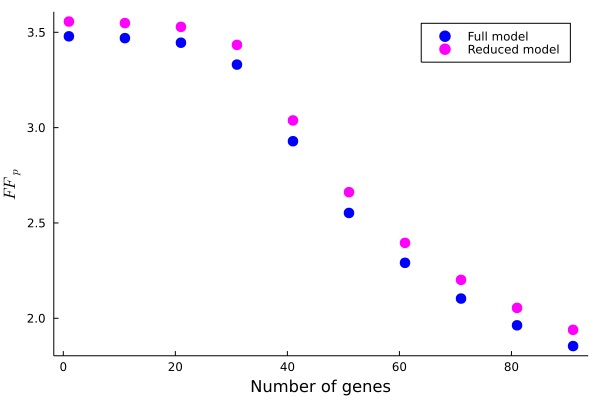

In [10]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false)

In [11]:
savefig("../../data/figures-for-paper/full_model_verses_reduced_model_$(N)_genes.svg")

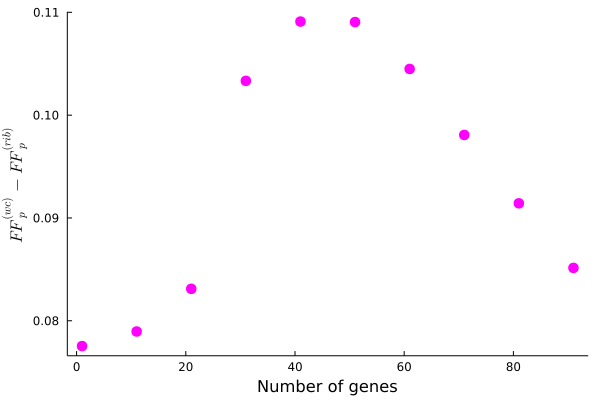

In [12]:
scatter(
    xs,
    ffs_red-ffs_full,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [13]:
savefig("../../data/figures-for-paper/residuals_full_model_ribosome_model_$(N)_genes.svg")

# Choosing Realistic Parameters

In [14]:
# Load data from schwannhauser
exp_data = DataFrame(CSV.File("../../data/experimental_data_sanitised.csv"))
dropmissing!(exp_data)
names(exp_data)

7-element Vector{String}:
 "id"
 "pNumber"
 "mNumber"
 "alpha"
 "beta"
 "mHalfLife"
 "pHalfLife"

In [15]:
median(exp_data[!, :pNumber])

41913.32

In [16]:
mean(exp_data[!, :pNumber])

475168.0025453261

In [17]:
sort(exp_data, [:pNumber])[50, :]

,id,pNumber,mNumber,alpha,beta,mHalfLife,pHalfLife
,String,Float64,Float64,Float64,Float64,Float64,Float64
50,IPI00136246.1,343.98,17.43,2.0,1.57,8.54,39.97


In [18]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(
        ps, 
        [
            1.9, # mRNA creation
            log(2)/8.54, # mRNA degredation
            .01, # binding to polysome
            0.001, # unbinding from polysome
            5.0, # translation,
            .1, # monosome decay
            .1 # protein decay
        ]
    )
end


prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 10000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts = map(x -> x[2], sol.u)
monosome_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
ribosome_counts = map(x -> x[1], sol.u)

print("
    mRNA counts: $(mean(mrna_counts + monosome_counts))\n
    unbound mRNA counts: $(mean(mrna_counts))\n
    protein counts: $(mean(protein_counts))\n
    ribosomes counts: $(mean(ribosome_counts))\n
    ")


    mRNA counts: 21.226460977353902

    unbound mRNA counts: 11.822989717701029

    protein counts: 470.1744210825579

    ribosomes counts: 406.0090840990916

    

In [19]:
mean(mrna_counts + monosome_counts)

21.226460977353902

In [20]:
mean(mrna_counts)

11.822989717701029

In [21]:
mean(protein_counts)

470.1744210825579

In [22]:
mean(ribosome_counts)

406.0090840990916

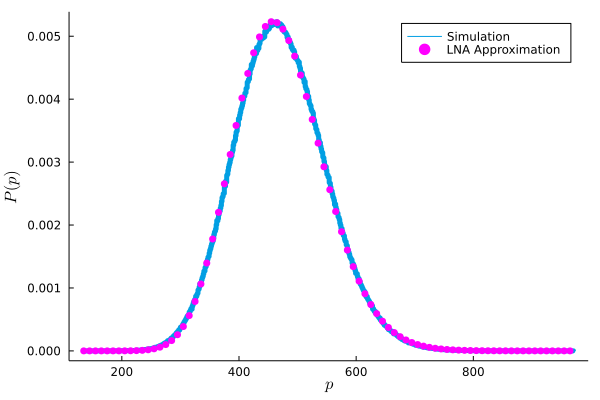

In [23]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(protein_counts):step:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [24]:
savefig("../../data/figures-for-paper/protein_count_$(N)_genes_IPI00136246.svg")

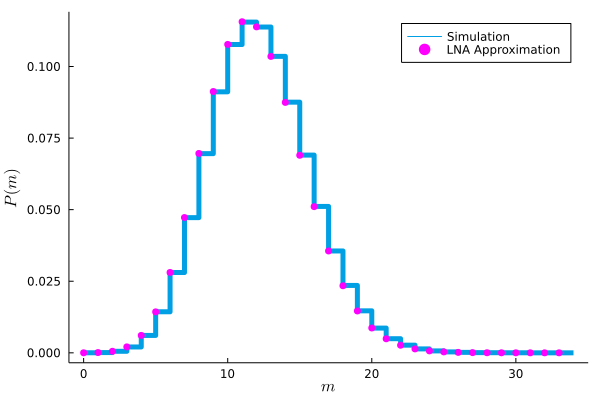

In [25]:
mrna_mean = lnameans[2]
mrna_var = lnacovs[2,2]

p = mrna_mean/mrna_var
r = mrna_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 1
xs = [minimum(mrna_counts):step:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"m", 
    ylabel=L"P(m)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [26]:
savefig("../../data/figures-for-paper/mrna_count_$(N)_genes_IPI00136246.svg")

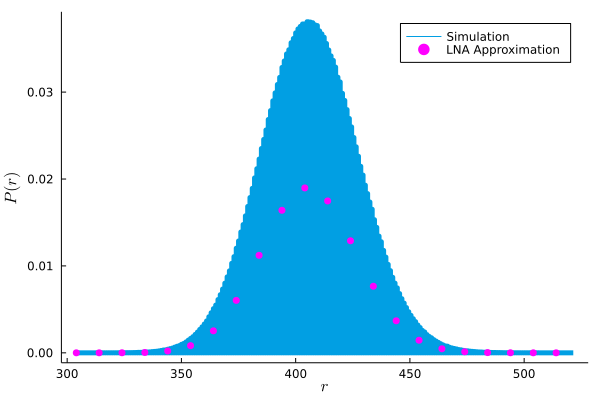

In [27]:
rib_counts = ribosome_counts
rib_mean = lnameans[1]
rib_var = lnacovs[1,1]

p = rib_mean/rib_var
r = rib_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(rib_counts):step:maximum(rib_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    rib_counts, 
    nbins=400, 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"r", 
    ylabel=L"P(r)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [28]:
savefig("../../data/figures-for-paper/rib_count_$(N)_genes_IPI00136246.svg")

# Comparing Differences for Large Number of Genes

The first idea here is to use the IPI00136246 gene and have N perturbed copies. The total number of ribosomes will need to be much larger than the number of proteins.

In [29]:
N = 151
xs = 1:10:N
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

p_mean_full = zeros(length(xs))
p_mean_red = zeros(length(xs))

for i in ProgressBar(1:length(xs))
    N = xs[i]
    rn = generate_rn(N)

    
    ps = [50., .1]
    for i in ProgressBar(1:N)
        ps = vcat(
            ps, 
            [
                1.9, # mRNA creation
                log(2)/8.54, # mRNA degredation
                .01, # binding to polysome
                0.001, # unbinding from polysome
                5.0, # translation,
                .1, # monosome decay
                .1 # protein decay
            ]
        )
        flush(stdout)
    end


    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
    
    p_mean_full[i] = lnameans[4]
end

0.0%┣                                               ┫ 0/16 [00:00<00:-1, -0s/it]
0.0%┣                                                ┫ 0/1 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, InfGs/it]
6.2%┣██▊                                        ┫ 1/16 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                               ┫ 0/11 [00:00<00:-1, -0s/it]
9.1%┣████                                       ┫ 1/11 [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████████████┫ 11/11 [00:00<00:00, 199it/s]
12.5%┣█████▉                                         ┫ 2/16 [00:01<00:07, 2it/s]
0.0%┣                                               ┫ 0/21 [00:00<00:-1, -0s/it]
4.8%┣██                                         ┫ 1/21 [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████████████┫ 21/21 [00:00<00:00, 398it/s]
18.8%┣████████▉             

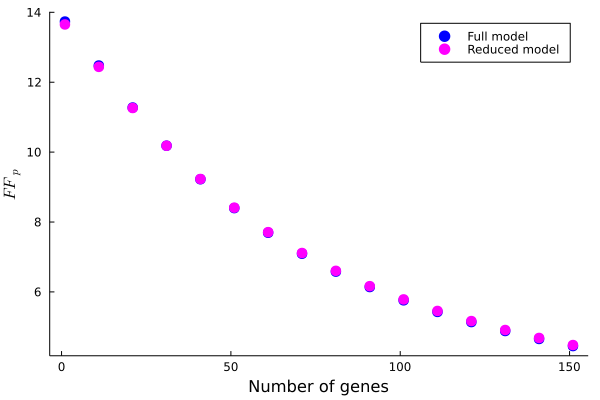

In [30]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [31]:
savefig("../../data/figures-for-paper/fano_factor_$(N)_copies_gene_IPI00136246.svg")

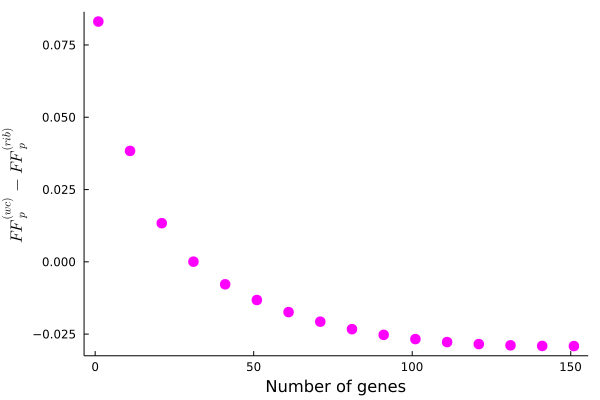

In [32]:
scatter(
    xs,
    ffs_full-ffs_red,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [33]:
savefig("../../data/figures-for-paper/fano_factor_difference_$(N)_copies_gene_IPI00136246.svg")

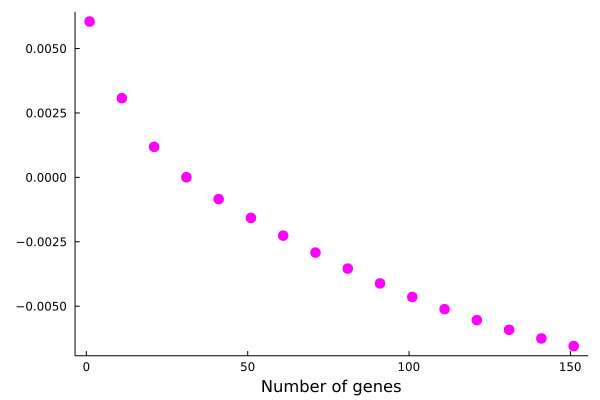

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [34]:
scatter(
    xs,
    (ffs_full .- ffs_red) ./ ffs_full,
    ylabel=L"\left(FF_p^{(wc)} - FF_p^{(rib)\right)/FF_p^{(wc)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [35]:
savefig("../../data/figures-for-paper/fano_factor_rel_error_$(N)_copies_gene_IPI00136246.svg")

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


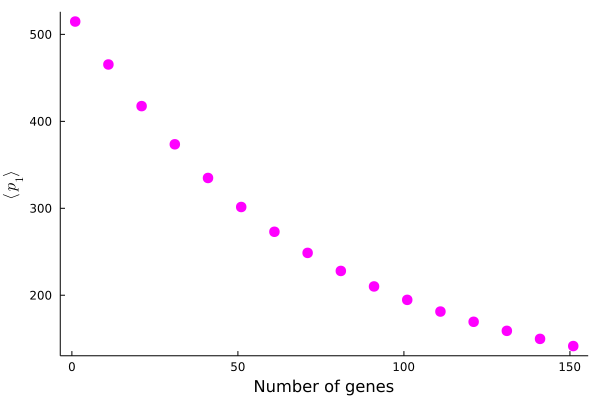

In [36]:
scatter(
    xs,
    p_mean_full,
    ylabel=L"\langle p_1 \rangle",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [37]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_copies_gene_IPI00136246.svg")

This assumes that the rate parameters are "real" variables which are independent of the number of genes. In reality the single gene model should have different inferred parameters which produce the same measured quantities, ie the gene number and decay rate. Since the decay rate is measurable we can keep those variables the same and only have to infer the protein constants.

## Keeping ribosome-gene ratio constant

In [38]:
N = 61
xs = 1:10:N
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

p_mean_full = zeros(length(xs))
p_mean_red = zeros(length(xs))

for i in ProgressBar(1:length(xs))
    N = xs[i]
    rn = generate_rn(N)

    
    ps = [50. * N, .1]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                1.9, # mRNA creation
                log(2)/8.54, # mRNA degredation
                .01, # binding to polysome
                0.001, # unbinding from polysome
                5.0, # translation,
                .1, # monosome decay
                .1 # protein decay
            ]
        )
    end


    prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
    
    p_mean_full[i] = lnameans[4]
end

0.0%┣                                                ┫ 0/7 [00:00<00:00, -0s/it]
14.3%┣██████▏                                    ┫ 1/7 [00:00<Inf:Inf, InfGs/it]
28.6%┣█████████████▊                                  ┫ 2/7 [00:00<00:02, 3it/s]
42.9%┣████████████████████▋                           ┫ 3/7 [00:02<00:05, 1s/it]
57.1%┣███████████████████████████▍                    ┫ 4/7 [00:08<00:08, 3s/it]
71.4%┣██████████████████████████████████▎             ┫ 5/7 [00:20<00:10, 5s/it]
85.7%┣█████████████████████████████████████████▏      ┫ 6/7 [00:44<00:09, 9s/it]
100.0%┣██████████████████████████████████████████████┫ 7/7 [01:26<00:00, 14s/it]
100.0%┣██████████████████████████████████████████████┫ 7/7 [01:26<00:00, 14s/it]


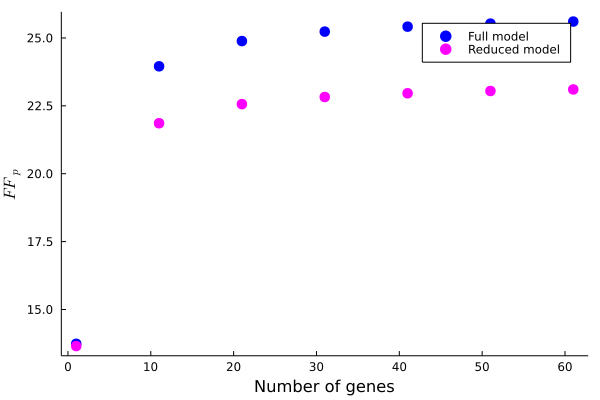

In [39]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [40]:
savefig("../../data/figures-for-paper/rib_const_fano_factor_$(N)_copies_gene_IPI00136246.svg")

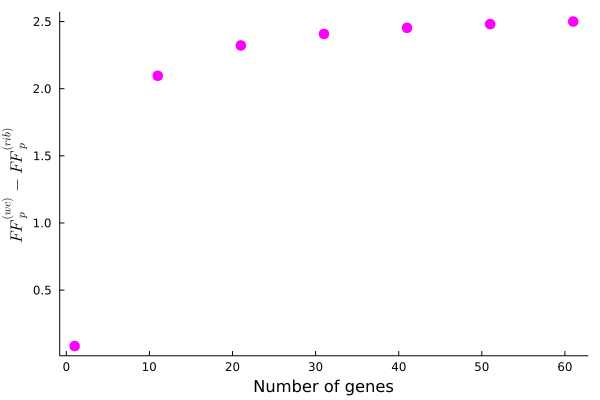

In [41]:
scatter(
    xs,
    ffs_full-ffs_red,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [42]:
savefig("../../data/figures-for-paper/rib_const_fano_factor_residual_$(N)_copies_gene_IPI00136246.svg")

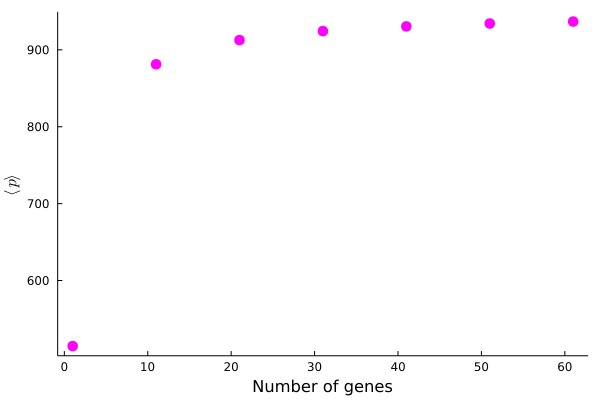

In [43]:
scatter(
    xs,
    p_mean_full,
    ylabel=L"\langle p \rangle",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false,
    grid=false
)

In [44]:
savefig("../../data/figures-for-paper/rib_const_protein_copy_number_$(N)_copies_gene_IPI00136246.svg")

# Using an array of different genes.

## Whole cell model

In [31]:
N = 10
rn = generate_rn(N)

ps = [N*10*10*log(2)/1200., log(2)/1200.] # [ribosome production, ribosome degredation]
for j in 1:N
    ps = vcat(
        ps, 
        [
            rand(Normal(log(2)/210*5, 0.1*log(2)/210*5)), # mRNA creation
            rand(Normal(log(2)/210 + log(2)/1200, 0.1*log(2)/210 + log(2)/1200)), # mRNA degredation
            rand(Normal(.0001, 0.1*.0001)), # binding to polysome
            rand(Normal(0.0001, 0.00001)), # unbinding from polysome
            rand(Normal(0.1,0.01)), # translation,
            rand(Normal(log(2)/1200., 0.1*log(2)/1200.)), # monosome decay
            rand(Normal(log(2)/1200., 0.1*log(2)/1200)) # protein decay
        ]
    )
end

In [32]:
prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 100000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts = map(x -> x[2], sol.u)
monosome_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
ribosome_counts = map(x -> x[1], sol.u)

100000001-element Vector{Int64}:
  963
  964
  962
  958
  961
  961
  959
  958
  959
  959
  960
  961
  965
    ⋮
 1008
 1005
 1008
 1010
 1010
 1008
 1004
 1006
 1006
 1007
 1003
 1002

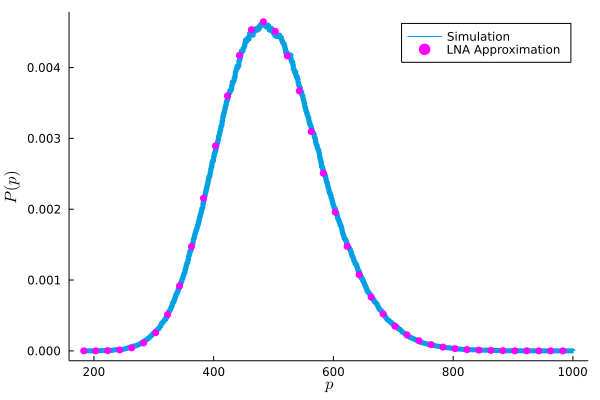

In [33]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 20
xs_wc = [minimum(protein_counts):step:maximum(protein_counts)]
ys_wc = Distributions.pdf(nb, xs_wc)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

## Canonical model

In [34]:
rn_can = @reaction_network begin
    k1, 0 --> m
    k2, m --> 0
    k3, m --> m + p
    k6, p --> 0
end k1 k2 k3 k6

Model ##ReactionSystem#306 with 4 equations
States (2):
  m(t)
  p(t)
Parameters (4):
  k1
  k2
  k3
  k6

In [35]:
ps_can =[
    ps[3], # mRNA creation
    ps[4], # mRNA degredation
    ps[4]*ps[9]*lnameans[4]/ps[3], # translation,
    ps[9] # protein decay
]

4-element Vector{Float64}:
 0.01741957875417873
 0.004108756343473096
 0.07324541226133473
 0.0006254724561137905

In [36]:
prob = LNAProblem(rn_can, zeros(Int, 2), ps_can)

sol = solve(prob)

lnameans_can = mean(sol)
lnacovs_can = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans_can))

prob = DiscreteProblem(rn_can, initial_values, (0, 190000000.),  ps_can)
jump_prob = JumpProblem(rn_can, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts_can = map(x -> x[1], sol.u)
protein_counts_can = map(x -> x[2], sol.u)

190000001-element Vector{Int64}:
 497
 498
 496
 496
 497
 497
 497
 498
 499
 500
 500
 500
 499
   ⋮
 485
 485
 487
 485
 484
 484
 484
 484
 481
 481
 481
 481

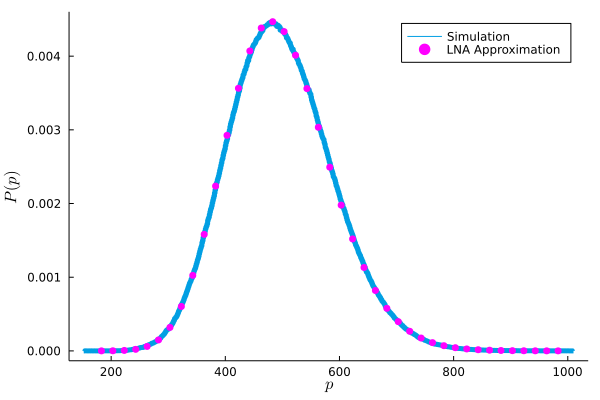

In [37]:
prot_mean = lnameans_can[2]
prot_var = lnacovs_can[2,2]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 20
xs_can = [minimum(protein_counts):step:maximum(protein_counts)]
ys_can = Distributions.pdf(nb, xs_can)

histogram(
    protein_counts_can, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_can,
    ys_can, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

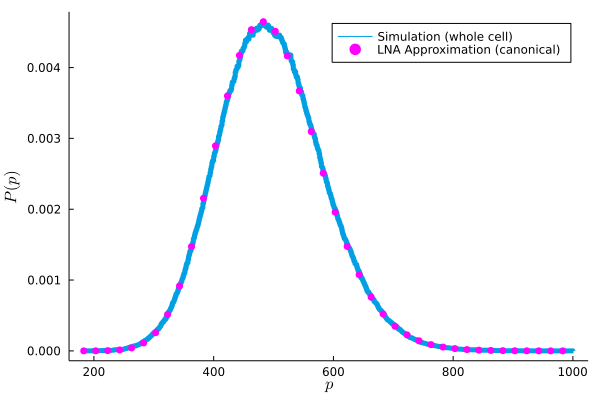

In [38]:
histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation (whole cell)",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

## Ribosome model

In [39]:
rn_rib = @reaction_network begin
    k1, 0 --> r
    k2, r --> 0
    k3, 0 --> m
    k4, m --> 0
    k5, m + r --> m + r + p
    k6, p --> 0
end k1 k2 k3 k4 k5 k6

Model ##ReactionSystem#309 with 6 equations
States (3):
  r(t)
  m(t)
  p(t)
Parameters (6):
  k1
  k2
  k3
  k4
  k5
  k6

In [40]:
ps_rib = [
    ps[1], # rib creation
    ps[2], # rib degredation
    ps[3], # mrna creation
    ps[4], # mrna degredation
    ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1]), # translation
    ps[2], # protein degredation = rib degredation
]

prob = LNAProblem(rn_rib, zeros(Int, 3), ps_rib)

sol = solve(prob)

lnameans_rib = mean(sol)
lnacovs_rib = StatsBase.cov(sol)

prot_mean = lnameans_rib[3]
prot_var = lnacovs_rib[3,3]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb_rib = NegativeBinomial(r,p)
step = 20
xs_rib = [minimum(protein_counts):step:maximum(protein_counts)]
ys_rib = Distributions.pdf(nb_rib, xs_rib)

1-element Vector{Vector{Float64}}:
 [1.4773944340566818e-7, 9.096481859004972e-7, 4.258056043143564e-6, 1.5837540505500333e-5, 4.843774628176277e-5, 0.00012516444662270451, 0.0002792967897811099, 0.0005478879664863076, 0.0009589060408980008, 0.0015159726699891024  …  3.599277655732574e-5, 2.1252041527182693e-5, 1.2316851243692522e-5, 7.0126873841190265e-6, 3.925562659131098e-6, 2.1621012144480952e-6, 1.1724920339524712e-6, 6.264515660124294e-7, 3.299705545457341e-7, 1.7144435099919184e-7]

In [41]:
rn_rib_bound = @reaction_network begin
    k1, 0 --> r
    k2, r --> 0
    k3, 0 --> m
    k4, m --> 0
    k5, m + r --> m + r + p
    k6, p --> 0
    k7, r --> rb
    k8, rb --> r
    k9, rb --> 0
end k1 k2 k3 k4 k5 k6 k7 k8 k9

Model ##ReactionSystem#310 with 9 equations
States (4):
  r(t)
  m(t)
  p(t)
  rb(t)
Parameters (9):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [42]:
indexes = 5+7:7:length(ps)
length(ps)
rib_binding = sum(getindex(ps, indexes))
rib_unbinding = sum(getindex(ps, indexes .+ 1)) + sum(getindex(ps, indexes .+ 2))

0.9263452022001095

## Bound ribosome model

In [43]:
ps_rib_bound = [
    ps[1], # rib creation
    ps[2], # rib degredation
    ps[3], # mrna creation
    ps[4], # mrna degredation
    ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1]), # translation
    ps[2], # protein degredation = rib degredation
    rib_binding, # rib binding
    rib_unbinding, # rib unbinding
    ps[2], # bound ribosome degredation
]

prob = LNAProblem(rn_rib_bound, zeros(Int, 4), ps_rib_bound)

sol = solve(prob)

lnameans_rib_bound = mean(sol)
lnacovs_rib_bound = StatsBase.cov(sol)

prot_mean = lnameans_rib_bound[3]
prot_var = lnacovs_rib_bound[3,3]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb_rib_bound = NegativeBinomial(r,p)
step = 20
xs_rib_bound = [minimum(protein_counts):step:maximum(protein_counts)]
ys_rib_bound = Distributions.pdf(nb_rib_bound, xs_rib_bound)

1-element Vector{Vector{Float64}}:
 [1.5073608756711104e-7, 9.269096314890701e-7, 4.3332971342135544e-6, 1.6096742486019895e-5, 4.916741194124824e-5, 0.00012688712830845667, 0.000282778049574258, 0.0005540062693972816, 0.0009683718135931271, 0.0015289758505146237  …  3.529185149459437e-5, 2.081147810424896e-5, 1.204606340641159e-5, 6.849724523792779e-6, 3.829426328522224e-6, 2.106449268908787e-6, 1.140848728758519e-6, 6.087638290484392e-7, 3.202430448216189e-7, 1.6617698631648634e-7]

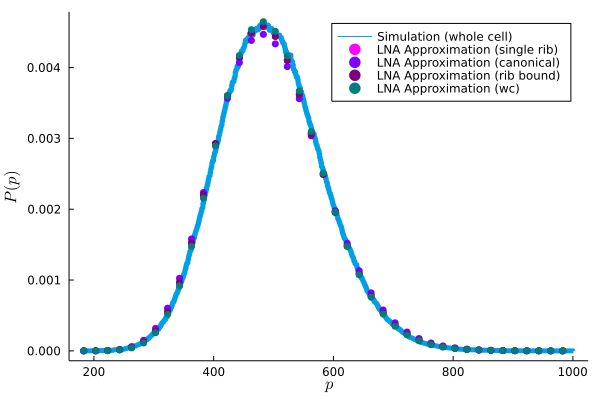

In [44]:
histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation (whole cell)",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_rib,
    ys_rib, 
    label="LNA Approximation (single rib)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_can,
    ys_can, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_rib_bound,
    ys_rib_bound, 
    label="LNA Approximation (rib bound)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 125/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation (wc)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(0/255, 125/255, 125/255, 255/255),
    markerstrokecolor=RGBA(0/255, 125/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

## Bound ribosome with intermediary model

In [45]:
rn_rib_bound_int = @reaction_network begin
    k1, 0 --> r
    k2, r --> 0
    k3, 0 --> m
    k4, m --> 0
    k5, m + r --> rs
    k6, rs --> m + r
    k7, rs --> m + r + p
    k8, p --> 0
    k9, rs --> 0 
    k10, r --> rb
    k11, rb --> r
    k12, rb --> 0
end k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12

Model ##ReactionSystem#312 with 12 equations
States (5):
  r(t)
  m(t)
  rs(t)
  p(t)
  rb(t)
Parameters (12):
  k1
  k2
  k3
  k4
  k5
  k6
⋮

In [46]:
indexes = 5+7:7:length(ps)
rib_binding = sum(getindex(ps, indexes))
rib_unbinding = sum(getindex(ps, indexes .+ 1)) + sum(getindex(ps, indexes .+ 2))

0.9263452022001095

In [47]:
species(rn_rib_bound_int)

5-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 r(t)
 m(t)
 rs(t)
 p(t)
 rb(t)

In [48]:
ps_rib_bound_int = [
    ps[1], # rib creation
    ps[2], # rib degredation
    ps[3], # mrna creation
    ps[4], # mrna degredation
    ps[5],# rib binding
    ps[6],# rib unbinding
    ps[7], # translation
    ps[2], # protein degredation = rib degredation
    ps[2], # monosome degredation
    rib_binding, # rib binding
    rib_unbinding, # rib unbinding
    ps[2], # bound ribosome degredation
]

prob = LNAProblem(rn_rib_bound_int, ones(Int, 5) ./2, ps_rib_bound_int)

sol = solve(prob)

lnameans_rib_bound_int = mean(sol)
lnacovs_rib_bound_int = StatsBase.cov(sol)

prot_mean = lnameans_rib_bound_int[4]
prot_var = lnacovs_rib_bound_int[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb_rib_bound_int = NegativeBinomial(r,p)
step = 20
xs_rib_bound_int = [minimum(protein_counts):step:maximum(protein_counts)]
ys_rib_bound_int = Distributions.pdf(nb_rib_bound_int, xs_rib_bound_int)

1-element Vector{Vector{Float64}}:
 [7.162014434493369e-9, 5.906038234655325e-8, 3.6145752262490567e-7, 1.7221042639803493e-6, 6.628594817497193e-6, 2.1228549024133157e-5, 5.792372416312361e-5, 0.00013729539805546295, 0.00028727619700436285, 0.0005378188761740945  …  0.00014000594925863078, 8.901458854599086e-5, 5.5448179724588166e-5, 3.387138517227732e-5, 2.0308546729153526e-5, 1.19613598012883e-5, 6.925812926137382e-6, 3.945128379265458e-6, 2.2123005751256667e-6, 1.2220654187504606e-6]

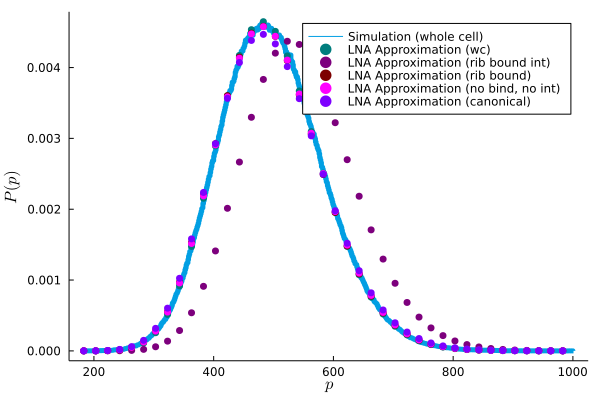

In [49]:
histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation (whole cell)",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs_wc,
    ys_wc, 
    label="LNA Approximation (wc)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(0/255, 125/255, 125/255, 255/255),
    markerstrokecolor=RGBA(0/255, 125/255, 125/255, 255/255),
    grid=false,
    markersize=4
)


scatter!(
    xs_rib_bound_int,
    ys_rib_bound_int, 
    label="LNA Approximation (rib bound int)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 125/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_rib_bound,
    ys_rib_bound, 
    label="LNA Approximation (rib bound)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 0/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 0/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_rib,
    ys_rib, 
    label="LNA Approximation (no bind, no int)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_can,
    ys_can, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [50]:
savefig("../../data/figures-for-paper/model_comparison_$(N)_genes_e_coli.svg")

In [51]:
mean(nb_rib_bound_int)

543.7442979690624

In [52]:
mean(nb_rib_bound)

495.9787841446007

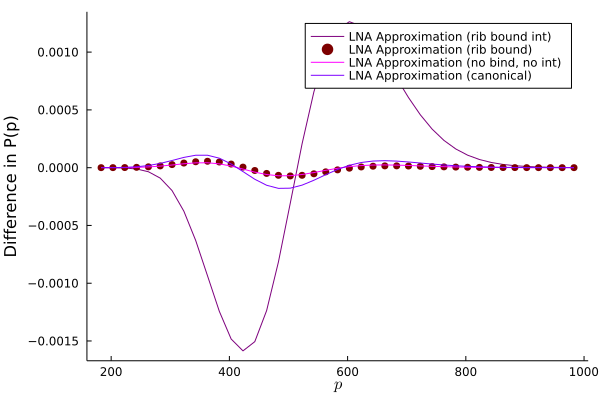

In [53]:
plot(
    xs_rib_bound_int,
    ys_rib_bound_int .- ys_wc, 
    label="LNA Approximation (rib bound int)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 125/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 125/255, 255/255),
    grid=false,
    markersize=4
)

scatter!(
    xs_rib_bound,
    ys_rib_bound .- ys_wc, 
    label="LNA Approximation (rib bound)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(125/255, 0/255, 0/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 0/255, 255/255),
    grid=false,
    markersize=4
)

plot!(
    xs_rib,
    ys_rib .- ys_wc, 
    label="LNA Approximation (no bind, no int)", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

plot!(
    xs_can,
    ys_can .- ys_wc, 
    label="LNA Approximation (canonical)", 
    xlabel=L"p", 
    ylabel="Difference in P(p)",
    color = RGBA(125/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(125/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [54]:
FF_wc(lnameans, lnacovs)

15.201898482268362

In [55]:
FF_can(lnameans_can, lnacovs_can)

16.47145593524787

In [56]:
FF_rib(lnameans_rib, lnacovs_rib)

15.681984197826745

In [57]:
FF_rib_bound(lnameans_rib_bound, lnacovs_rib_bound)

15.667238694693

In [58]:
FF_rib_bound_int(lnameans_rib_bound_int, lnacovs_rib_bound_int)

15.611036991104472

# Error in Fano Factor against ribosome condition

In [2]:
function ps_can_f(ps, lnameans)
    trans_rib = ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1])
    rib_count = ps[1]/ps[2]
    return [
        ps[3], # mRNA creation
        ps[4], # mRNA degredation
        trans_rib*rib_count, # translation,
        ps[9] # protein decay
    ]
end

function ps_rib_f(ps, lnameans)
    return [
        ps[1], # rib creation
        ps[2], # rib degredation
        ps[3], # mrna creation
        ps[4], # mrna degredation
        ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1]), # translation
        ps[2], # protein degredation = rib degredation
    ]
end

function ps_rib_bound_f(ps,lnameans)
    indexes = 5+7:7:length(ps)
    rib_binding = sum(getindex(ps, indexes))
    rib_unbinding = sum(getindex(ps, indexes .+ 1)) + sum(getindex(ps, indexes .+ 2))
    return [
        ps[1], # rib creation
        ps[2], # rib degredation
        ps[3], # mrna creation
        ps[4], # mrna degredation
        ps[4]*ps[2]*ps[2]*lnameans[4]/(ps[3]*ps[1]), # translation
        ps[2], # protein degredation = rib degredation
        rib_binding, # rib binding
        rib_unbinding, # rib unbinding
        ps[2], # bound ribosome degredation
    ]
end

function ps_rib_bound_int_f(ps)
    indexes = 5+7:7:length(ps)
    rib_binding = sum(getindex(ps, indexes))
    rib_unbinding = sum(getindex(ps, indexes .+ 1)) + sum(getindex(ps, indexes .+ 2))
    return [
        ps[1], # rib creation
        ps[2], # rib degredation
        ps[3], # mrna creation
        ps[4], # mrna degredation
        ps[5],# rib binding
        ps[6],# rib unbinding
        ps[7], # translation
        ps[2], # protein degredation = rib degredation
        ps[2], # monosome degredation
        rib_binding, # rib binding
        rib_unbinding, # rib unbinding
        ps[2], # bound ribosome degredation
    ]
end

ps_rib_bound_int_f (generic function with 1 method)

In [32]:
N_samples = 1000
FFs_can = zeros(N_samples)
FFs_rib = zeros(N_samples)
FFs_rib_bound = zeros(N_samples)
FFs_rib_bound_int = zeros(N_samples)
FFs_wc = zeros(N_samples)
rib_conditions = zeros(N_samples)

for i in 1:N_samples
    N = 10
    ps = [N*10*10*log(2)/1200., log(2)/1200.] # [ribosome production, ribosome degredation]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                rand(Normal(log(2)/210*5, 0.1*log(2)/210*5)), # mRNA creation
                rand(Normal(log(2)/210 + log(2)/1200, 0.1*log(2)/210 + log(2)/1200)), # mRNA degredation
                rand(Normal(.0001, 0.1*.0001)), # binding to polysome
                rand(Normal(0.0001, 0.00001)), # unbinding from polysome
                rand(Normal(0.1,0.01)), # translation,
                rand(Normal(log(2)/1200., 0.1*log(2)/1200.)), # monosome decay
                rand(Normal(log(2)/1200., 0.1*log(2)/1200)) # protein decay
            ]
        )
    end

    rn = generate_rn(N)
    prob = LNAProblem(rn, ones(Int, length(species(rn))) ./2, ps)
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    
    if minimum(lnameans) <= 0
        print("negative value")
        continue
    end
    
    rn_can = rn_can_f()
    prob = LNAProblem(rn_can, ones(Int, length(species(rn_can))) ./2, ps_can_f(ps, lnameans))
    sol = solve(prob)
    lnameans_can = mean(sol)
    lnacovs_can = StatsBase.cov(sol)

    rn_rib = rn_rib_f()
    prob = LNAProblem(rn_rib, ones(Int, length(species(rn_rib))) ./2, ps_rib_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib = mean(sol)
    lnacovs_rib = StatsBase.cov(sol)

    rn_rib_bound = rn_rib_bound_f()
    prob = LNAProblem(rn_rib_bound, ones(Int, length(species(rn_rib_bound))) ./2, ps_rib_bound_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib_bound = mean(sol)
    lnacovs_rib_bound = StatsBase.cov(sol)

    rn_rib_bound_int = rn_rib_bound_int_f()
    prob = LNAProblem(rn_rib_bound_int, ones(Int, length(species(rn_rib_bound_int))) ./2, ps_rib_bound_int_f(ps))
    sol = solve(prob)
    lnameans_rib_bound_int = mean(sol)
    lnacovs_rib_bound_int = StatsBase.cov(sol)
    
    FFs_can[i] = FF_can(lnameans_can, lnacovs_can)
    FFs_rib[i] = FF_rib(lnameans_rib, lnacovs_rib)
    FFs_rib_bound[i] = FF_rib_bound(lnameans_rib_bound, lnacovs_rib_bound)
    FFs_rib_bound_int[i] = FF_rib_bound_int(lnameans_rib_bound_int, lnacovs_rib_bound_int)
    FFs_wc[i] = FF_wc(lnameans, lnacovs)
    
    rib_species_index = 3:3:length(species(rn))
    rib_conditions[i] = lnameans[3] /(lnameans[1] + sum(lnameans[rib_species_index]))
end

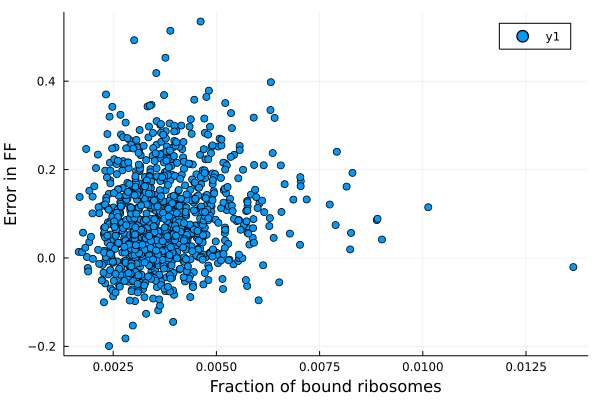

In [4]:
scatter(rib_conditions, (FFs_can - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes")

In [33]:
N_samples = 1000
FFs_can = zeros(N_samples)
FFs_rib = zeros(N_samples)
FFs_rib_bound = zeros(N_samples)
FFs_rib_bound_int = zeros(N_samples)
FFs_wc = zeros(N_samples)
rib_conditions = zeros(N_samples)

for i in 1:N_samples
    N = 10
    ps = [rand(), rand()] # [ribosome production, ribosome degredation]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                rand(), # mRNA creation
                rand(), # mRNA degredation
                rand(), # binding to polysome
                rand(), # unbinding from polysome
                rand(), # translation,
                rand(), # monosome decay
                rand() # protein decay
            ]
        )
    end

    rn = generate_rn(N)
    prob = LNAProblem(rn, ones(Int, length(species(rn))) ./2, ps)
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    if minimum(lnameans) <= 0
        print("negative value")
        continue
    end
    
    rn_can = rn_can_f()
    prob = LNAProblem(rn_can, ones(Int, length(species(rn_can))) ./2, ps_can_f(ps, lnameans))
    sol = solve(prob)
    lnameans_can = mean(sol)
    lnacovs_can = StatsBase.cov(sol)

    rn_rib = rn_rib_f()
    prob = LNAProblem(rn_rib, ones(Int, length(species(rn_rib))) ./2, ps_rib_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib = mean(sol)
    lnacovs_rib = StatsBase.cov(sol)

    rn_rib_bound = rn_rib_bound_f()
    prob = LNAProblem(rn_rib_bound, ones(Int, length(species(rn_rib_bound))) ./2, ps_rib_bound_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib_bound = mean(sol)
    lnacovs_rib_bound = StatsBase.cov(sol)

    rn_rib_bound_int = rn_rib_bound_int_f()
    prob = LNAProblem(rn_rib_bound_int, ones(Int, length(species(rn_rib_bound_int))) ./2, ps_rib_bound_int_f(ps))
    sol = solve(prob)
    lnameans_rib_bound_int = mean(sol)
    lnacovs_rib_bound_int = StatsBase.cov(sol)
    
    FFs_can[i] = FF_can(lnameans_can, lnacovs_can)
    FFs_rib[i] = FF_rib(lnameans_rib, lnacovs_rib)
    FFs_rib_bound[i] = FF_rib_bound(lnameans_rib_bound, lnacovs_rib_bound)
    FFs_rib_bound_int[i] = FF_rib_bound_int(lnameans_rib_bound_int, lnacovs_rib_bound_int)
    FFs_wc[i] = FF_wc(lnameans, lnacovs)
    
    rib_species_index = 3:3:length(species(rn))
    rib_conditions[i] = lnameans[3] /(lnameans[1] + sum(lnameans[rib_species_index]))
end

negative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative value

In [34]:
species(rn)[1]

R(t)

In [35]:
species(rn)[3]

MR1(t)

In [36]:
species(rn)[3:3:length(species(rn))]

10-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 MR1(t)
 MR2(t)
 MR3(t)
 MR4(t)
 MR5(t)
 MR6(t)
 MR7(t)
 MR8(t)
 MR9(t)
 MR10(t)

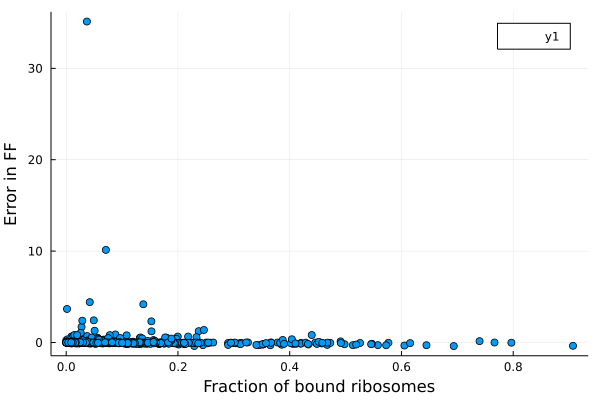

In [37]:
scatter(rib_conditions, (FFs_can - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes",
)

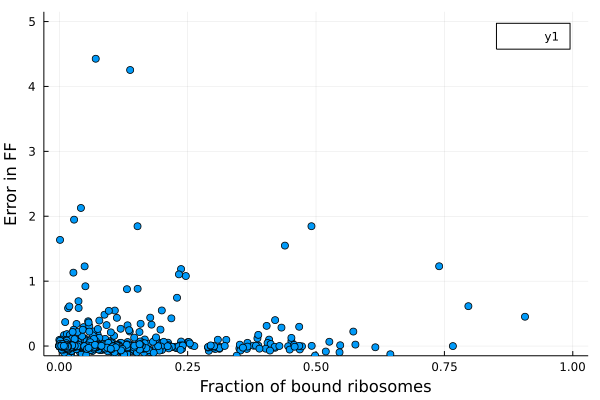

In [38]:
scatter(rib_conditions, (FFs_rib_bound - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes",
    xlims=[0,1.0],
    ylims=[0,5.0]
)

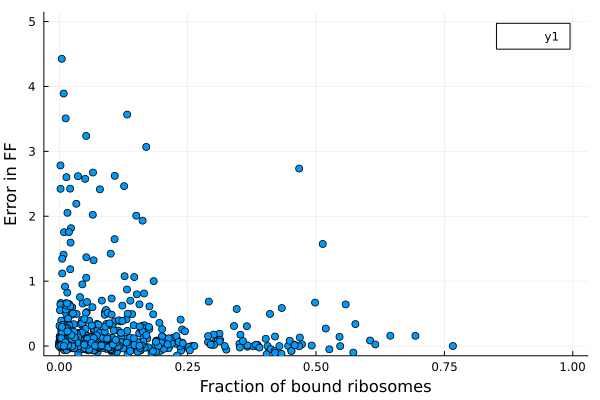

In [39]:
scatter(rib_conditions, (FFs_rib_bound_int - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes",
    xlims=[0,1.0],
    ylims=[0,5.0]
)

In [30]:
N_samples = 1000
FFs_can = zeros(N_samples)
FFs_rib = zeros(N_samples)
FFs_rib_bound = zeros(N_samples)
FFs_rib_bound_int = zeros(N_samples)
FFs_wc = zeros(N_samples)
rib_conditions = zeros(N_samples)

for i in 1:N_samples
    N = 10
    ps = [rand(), rand()] # [ribosome production, ribosome degredation]
    for j in 1:N
        ps = vcat(
            ps, 
            [
                rand(), # mRNA creation
                rand(), # mRNA degredation
                rand(), # binding to polysome
                rand(), # unbinding from polysome
                rand(), # translation,
                rand(), # monosome decay
                rand() # protein decay
            ]
        )
    end

    rn = generate_rn(N)
    prob = LNAProblem(rn, ones(Int, length(species(rn))) ./2, ps)
    sol = solve(prob)
    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)
    
    if minimum(lnameans) <= 0
        print("negative value")
        continue
    end
    
    rn_can = rn_can_f()
    prob = LNAProblem(rn_can, ones(Int, length(species(rn_can))) ./2, ps_can_f(ps, lnameans))
    sol = solve(prob)
    lnameans_can = mean(sol)
    lnacovs_can = StatsBase.cov(sol)

    rn_rib = rn_rib_f()
    prob = LNAProblem(rn_rib, ones(Int, length(species(rn_rib))) ./2, ps_rib_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib = mean(sol)
    lnacovs_rib = StatsBase.cov(sol)

    rn_rib_bound = rn_rib_bound_f()
    prob = LNAProblem(rn_rib_bound, ones(Int, length(species(rn_rib_bound))) ./2, ps_rib_bound_f(ps, lnameans))
    sol = solve(prob)
    lnameans_rib_bound = mean(sol)
    lnacovs_rib_bound = StatsBase.cov(sol)

    rn_rib_bound_int = rn_rib_bound_int_f()
    prob = LNAProblem(rn_rib_bound_int, ones(Int, length(species(rn_rib_bound_int))) ./2, ps_rib_bound_int_f(ps))
    sol = solve(prob)
    lnameans_rib_bound_int = mean(sol)
    lnacovs_rib_bound_int = StatsBase.cov(sol)
    
    FFs_can[i] = FF_can(lnameans_can, lnacovs_can)
    FFs_rib[i] = FF_rib(lnameans_rib, lnacovs_rib)
    FFs_rib_bound[i] = FF_rib_bound(lnameans_rib_bound, lnacovs_rib_bound)
    FFs_rib_bound_int[i] = FF_rib_bound_int(lnameans_rib_bound_int, lnacovs_rib_bound_int)
    FFs_wc[i] = FF_wc(lnameans, lnacovs)
    
    rib_species_index = 3:3:length(species(rn))
    rib_conditions_across_mrna = zeros(length(rib_species_index))
    for k in 1:length(rib_species_index)
        rib_conditions_across_mrna[k] = lnameans[rib_species_index[k]] /(lnameans[1] + sum(lnameans[rib_species_index]))
    end
    rib_conditions[i] = maximum(rib_conditions_across_mrna)
end

negative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative valuenegative value

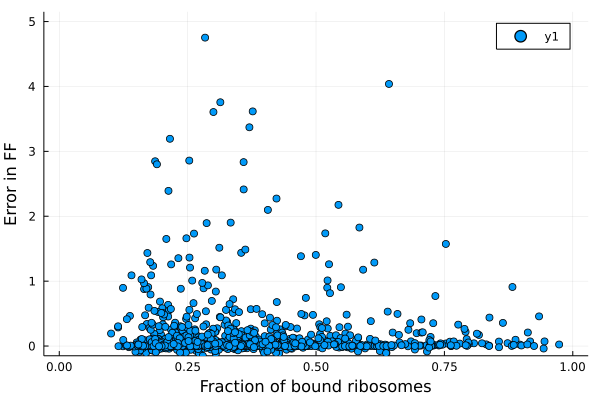

In [31]:
scatter(rib_conditions, (FFs_rib_bound_int - FFs_wc) ./ FFs_wc, ylabel="Error in FF", xlabel = "Fraction of bound ribosomes",
    xlims=[0,1.0],
    ylims=[0,5.0]
)